<a href="https://colab.research.google.com/github/kundajelab/adar_editing/blob/master/xgboost_with_shap/TTYH2_XGBOOST_WITH_TREESHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

## Uncomment these lines if running as a google colab notebook: 
#!pip install numpy==1.15
#! git clone https://github.com/kundajelab/adar_editing
#import os
#os.chdir("adar_editing/xgboost_with_shap/")
#!pip install shap
#!pip install --upgrade xgboost
#!pip install cufflinks
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))


In [1]:
%load_ext autoreload
%autoreload 2  

In [2]:
#helper utilities for model training and interpretation 
import shap
import sys 
sys.path.append('..')

from helpers import * 

#set a random seed so code is reproducible 
random.seed(1234)

# load JS visualization code to notebook
shap.initjs()
import warnings
warnings.filterwarnings('ignore')

#visualization utilities 
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import chart_studio.plotly as plotly
import numpy as np
from plotly.offline import iplot
from plotly.graph_objs import Heatmap

import feature_subsets
import xgboost


## Neil1 xgboost with TreeShap <a name='outline'>
<ol>
    <li><a href=#3>Computational Dataset</a></li>
    <li><a href=#4>Computational Dataset Feature Subsets</a></li>
    <li><a href=#5>Exclude mut features</a></li>
 </ol>


## TTYH2 Computational features <a name='3'>
<a href=#outline>Home</a>

In [3]:
import pandas as pd 
import xgboost 

In [4]:
data=pd.read_csv("../../xin_feature_matrices/ttyh2_computational.features.csv",header=0,sep=',',index_col=0)

In [5]:
#remove any null editing level values 
data=data[~data["editing_value"].isnull().values]

In [6]:
data=format_for_xgboost(data)

#set a random seed so code is reproducible 
random.seed(1234)
train_split,eval_split,test_split=split_train_test_eval_by_mut_pos(data)

(601, 205)
{21.0: 18, 22.0: 18, 23.0: 18, 24.0: 20, 25.0: 17, 26.0: 20, 27.0: 20, 28.0: 20, 29.0: 18, 30.0: 18, 31.0: 17, 32.0: 17, 33.0: 17, 34.0: 18, 35.0: 18, 36.0: 18, 79.0: 17, 80.0: 17, 81.0: 18, 82.0: 18, 83.0: 19, 84.0: 19, 85.0: 20, 86.0: 29, 88.0: 27, 89.0: 18, 90.0: 17, 91.0: 17, 92.0: 17, 93.0: 14, 94.0: 18, 95.0: 18, nan: 0, nan: 0, nan: 0, nan: 0, nan: 6}


In [7]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [8]:
#Remove any null features 
train_null=get_high_missingness_features(train_split)
eval_null=get_high_missingness_features(eval_split)
test_null=get_high_missingness_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [9]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
print("\n".join(to_drop))

u1_exist
mut_ref_struct:I
d1_length_internal_es
u1_length_hairpin
site_prev_nt:U
site_next_nt:A
u3_struct:I
u1_5prm_cp_bulge
u1_5prm_cp_hairpin
site_5prm_cp_internal:U:G
d3_5prm_cp_hairpin
site_prev_struct:S
d2_length_internal_es
u2_length_hairpin
site_next_struct:S
d3_length_hairpin
site_next_struct:B
u3_3prm_cp_internal:G:U
d2_5prm_cp_bulge:A:U
u1_distance
u2_struct:S
u2_length_bulge
d3_5prm_cp_internal
u3_length_internal_ecs
mut_ref_struct:B
mut_prev_struct:H
d1_3prm_cp_internal:A:U
u2_3prm_cp_internal:A:U
site_5prm_cp_bulge:U:G
d2_5prm_cp_internal:U:G
mut_ref_nt:U
site_next_nt:U
u3_5prm_cp_hairpin
u1_length_bulge
u3_length_internal_es
d2_5prm_cp_hairpin
u1_3prm_cp_bulge
d1_length_internal_ecs
u3_5prm_cp_bulge
mut_same_as_site
u1_5prm_cp_internal:U:A
d1_struct:I
site_length_bulge
u2_5prm_cp_internal:U:G
site_prev_struct:I
u1_length_internal_es
d1_5prm_cp_hairpin
d2_3prm_cp_internal:U:A
u2_5prm_cp_bulge:G:U
u1_length_internal_ecs
site_5prm_cp_hairpin
d3_5prm_cp_bulge:G:C
u2_5prm_cp_i

In [10]:
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [11]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)

eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)

test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [12]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(409, 99)
(409,)
(105, 99)
(105,)
(93, 99)
(93,)


In [13]:
## format matrixes for xgboost 
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [15]:
## set model training parameters 
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 
param['eval_metric'] = ['auc','mae','map','aucpr','rmse']

In [16]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [17]:
num_round = 1000
random.seed(1234)
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[0]	eval-auc:0.73300	eval-mae:0.28688	eval-map:1.00000	eval-aucpr:0.23125	eval-rmse:0.30019	train-auc:0.71655	train-mae:0.23024	train-map:1.00000	train-aucpr:0.33854	train-rmse:0.25248
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[1]	eval-auc:0.73105	eval-mae:0.21444	eval-map:1.00000	eval-aucpr:0.22893	eval-rmse:0.22873	train-auc:0.73423	train-mae:0.16520	train-map:1.00000	train-aucpr:0.34732	train-rmse:0.18393
[2]	eval-auc:0.74958	eval-mae:0.16217	eval-map:1.00000	eval-aucpr:0.23121	eval-rmse:0.17704	train-auc:0.74400	train-mae:0.12022	train-map:1.00000	train-aucpr:0.35262	train-rmse:0.13594
[3]	eval-auc:0.75845	eval-mae:0.12490	eval-map:1.00000	eval-aucpr:0.23816	eval-rmse:0.13806	train-auc:0.75243	train-mae:0.08844	train-map:1.00000	train-aucpr:0.36007	train-rmse:0.10190
[4]	eval-auc:0.76263	eval-mae:0.09795	eval-map:1.00000	eval-aucpr:0.24192	eval-rmse:0.11029	train-auc:0.75663	train

[44]	eval-auc:0.78221	eval-mae:0.03146	eval-map:1.00000	eval-aucpr:0.25171	eval-rmse:0.05511	train-auc:0.76694	train-mae:0.00345	train-map:1.00000	train-aucpr:0.37520	train-rmse:0.00493
[45]	eval-auc:0.78217	eval-mae:0.03141	eval-map:1.00000	eval-aucpr:0.25170	eval-rmse:0.05511	train-auc:0.76694	train-mae:0.00335	train-map:1.00000	train-aucpr:0.37521	train-rmse:0.00481
[46]	eval-auc:0.78217	eval-mae:0.03139	eval-map:1.00000	eval-aucpr:0.25170	eval-rmse:0.05510	train-auc:0.76695	train-mae:0.00324	train-map:1.00000	train-aucpr:0.37521	train-rmse:0.00467
[47]	eval-auc:0.78218	eval-mae:0.03134	eval-map:1.00000	eval-aucpr:0.25170	eval-rmse:0.05509	train-auc:0.76696	train-mae:0.00311	train-map:1.00000	train-aucpr:0.37522	train-rmse:0.00451
[48]	eval-auc:0.78217	eval-mae:0.03135	eval-map:1.00000	eval-aucpr:0.25170	eval-rmse:0.05509	train-auc:0.76696	train-mae:0.00302	train-map:1.00000	train-aucpr:0.37523	train-rmse:0.00439
[49]	eval-auc:0.78236	eval-mae:0.03133	eval-map:1.00000	eval-aucpr:0.2

[89]	eval-auc:0.78315	eval-mae:0.03062	eval-map:1.00000	eval-aucpr:0.25196	eval-rmse:0.05447	train-auc:0.76708	train-mae:0.00115	train-map:1.00000	train-aucpr:0.37537	train-rmse:0.00167
[90]	eval-auc:0.78315	eval-mae:0.03062	eval-map:1.00000	eval-aucpr:0.25196	eval-rmse:0.05447	train-auc:0.76708	train-mae:0.00115	train-map:1.00000	train-aucpr:0.37537	train-rmse:0.00167
Stopping. Best iteration:
[80]	eval-auc:0.78315	eval-mae:0.03062	eval-map:1.00000	eval-aucpr:0.25196	eval-rmse:0.05447	train-auc:0.76708	train-mae:0.00115	train-map:1.00000	train-aucpr:0.37537	train-rmse:0.00167



In [18]:
# save to binary file for faster loading
bst.save_model('ttyh2.computational.model')
# save model to text file 
bst.dump_model('ttyh2.computational.raw.txt')


In [19]:
## get model predictions on the test, training, and eval splits 
test_pred = bst.predict(dtest)
train_pred=bst.predict(dtrain)
eval_pred=bst.predict(deval)

In [20]:
## Get performance metrics on full dataset 
from helpers import * 
print_aggregate_peformance_metrics(train_y,train_pred,
                                   eval_y,eval_pred,
                                   test_y,test_pred,
                                  positive_thresh=0.2)

Train
	Spearman corr : SpearmanrResult(correlation=0.9997922430786328, pvalue=0.0)
	Pearson corr : (0.9999285486553167, 0.0)
	MAE : 0.0011485034138449405
	MAPE : 0.012696966438702774
	RMSE : 0.0016683325979521102
	auPRC : 0.999914208093021
	auROC : 0.999927735221853
Eval
	Spearman corr : SpearmanrResult(correlation=0.9294707150864433, pvalue=2.0733737499943076e-46)
	Pearson corr : (0.8830787777560953, 1.2575991697590772e-35)
	MAE : 0.030623529113538377
	MAPE : 0.4494435109535279
	RMSE : 0.05447099123534862
	auPRC : 0.8979782596817191
	auROC : 0.955535390199637
Test
	Spearman corr : SpearmanrResult(correlation=0.9122719348162748, pvalue=4.824793869913895e-37)
	Pearson corr : (0.8912346451419025, 5.275586931474995e-33)
	MAE : 0.029445262034734083
	MAPE : 0.3771998035136611
	RMSE : 0.0555089143593644
	auPRC : 0.8073901201487808
	auROC : 0.9545454545454546


In [21]:
## Correlation values 
from scipy.stats import spearmanr,pearsonr
spearman_train=spearmanr(train_y,train_pred)
spearman_eval=spearmanr(eval_y,eval_pred)
spearman_test=spearmanr(test_y,test_pred)

pearson_train=pearsonr(train_y,train_pred)
pearson_eval=pearsonr(eval_y,eval_pred)
pearson_test=pearsonr(test_y,test_pred)

print("Spearman correlation:")
print("Train:"+str(spearman_train))
print("Eval:"+str(spearman_eval))
print("Test:"+str(spearman_test))
print("\n")
print("Pearson correlation:")
print("Train:"+str(pearson_train))
print("Eval:"+str(pearson_eval))
print("Test:"+str(pearson_test))

Spearman correlation:
Train:SpearmanrResult(correlation=0.9997922430786328, pvalue=0.0)
Eval:SpearmanrResult(correlation=0.9294707150864433, pvalue=2.0733737499943076e-46)
Test:SpearmanrResult(correlation=0.9122719348162748, pvalue=4.824793869913895e-37)


Pearson correlation:
Train:(0.9999285486553167, 0.0)
Eval:(0.8830787777560953, 1.2575991697590772e-35)
Test:(0.8912346451419025, 5.275586931474995e-33)


In [22]:
## MAE
from sklearn.metrics import mean_absolute_error
mae_train=mean_absolute_error(train_y,train_pred)
print("MAE Train:"+str(mae_train))

mae_eval=mean_absolute_error(eval_y,eval_pred)
print("MAE Eval:"+str(mae_eval))

mae_test=mean_absolute_error(test_y,test_pred)
print("MAE Test:"+str(mae_test))


MAE Train:0.0011485034138449405
MAE Eval:0.030623529113538377
MAE Test:0.029445262034734083


In [23]:
## MAPE
pseudocount=0.01
mape_train=np.mean(np.abs((train_y - train_pred) /(pseudocount+train_y))) * 100
print("MAPE Train:"+str(mape_train)+"%")

mape_eval=np.mean(np.abs((eval_y - eval_pred) /(pseudocount+eval_y))) * 100
print("MAPE Eval:"+str(mape_eval)+"%")

mape_test=np.mean(np.abs((test_y - test_pred) /(pseudocount+test_y))) * 100
print("MAPE Test:"+str(mape_test)+"%")

MAPE Train:1.2696966438702775%
MAPE Eval:44.94435109535279%
MAPE Test:37.71998035136611%


In [24]:
## RMSE
from sklearn.metrics import mean_squared_error
import math 
rmse_train=math.sqrt(mean_squared_error(train_y,train_pred))
print("RMSE Train:"+str(rmse_train))

rmse_eval=math.sqrt(mean_squared_error(eval_y,eval_pred))
print("RMSE Eval:"+str(rmse_eval))

rmse_test=math.sqrt(mean_squared_error(test_y,test_pred))
print("RMSE Test:"+str(rmse_test))


RMSE Train:0.0016683325979521102
RMSE Eval:0.05447099123534862
RMSE Test:0.0555089143593644


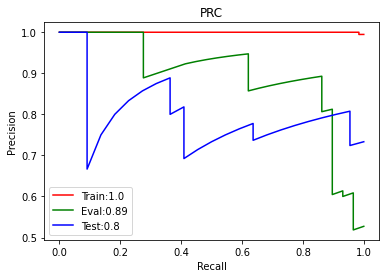

In [25]:
## PRC 
## PRC only valid for binary outcomes. 
## Editing levels < 0.2 are labeled as "0". 
## Editing levels >= 0.2 are labeled as "1". 

from sklearn.metrics import auc, precision_recall_curve

precision_train,recall_train,prc_thresholds_train=precision_recall_curve(train_y>=0.2,train_pred)
precision_eval,recall_eval,prc_thresholds_eval=precision_recall_curve(eval_y>=0.2,eval_pred)
precision_test,recall_test,prc_thresholds_test=precision_recall_curve(test_y>=0.2,test_pred)

auprc_train=auc(recall_train,precision_train)
auprc_eval=auc(recall_eval,precision_eval)
auprc_test=auc(recall_test,precision_test)

plt.plot(recall_train,precision_train,'r',label="Train:"+str(round(auprc_train,2)))
plt.plot(recall_eval,precision_eval,'g',label="Eval:"+str(round(auprc_eval,2)))
plt.plot(recall_test,precision_test,'b',label="Test:"+str(round(auprc_test,2)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PRC")
plt.legend()

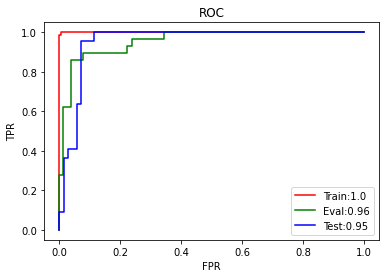

In [26]:
## ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr_train,tpr_train,roc_thresholds_train=roc_curve(train_y>=0.2,train_pred)
fpr_eval,tpr_eval,roc_thresholds_eval=roc_curve(eval_y>=0.2,eval_pred)
fpr_test,tpr_test,roc_thresholds_test=roc_curve(test_y>=0.2,test_pred)

auroc_train=roc_auc_score(train_y>=0.2,train_pred)
auroc_eval=roc_auc_score(eval_y>=0.2,eval_pred)
auroc_test=roc_auc_score(test_y>=0.2,test_pred)

plt.plot(fpr_train,tpr_train,'r',label="Train:"+str(round(auroc_train,2)))
plt.plot(fpr_eval,tpr_eval,'g',label="Eval:"+str(round(auroc_eval,2)))
plt.plot(fpr_test,tpr_test,'b',label="Test:"+str(round(auroc_test,2)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()

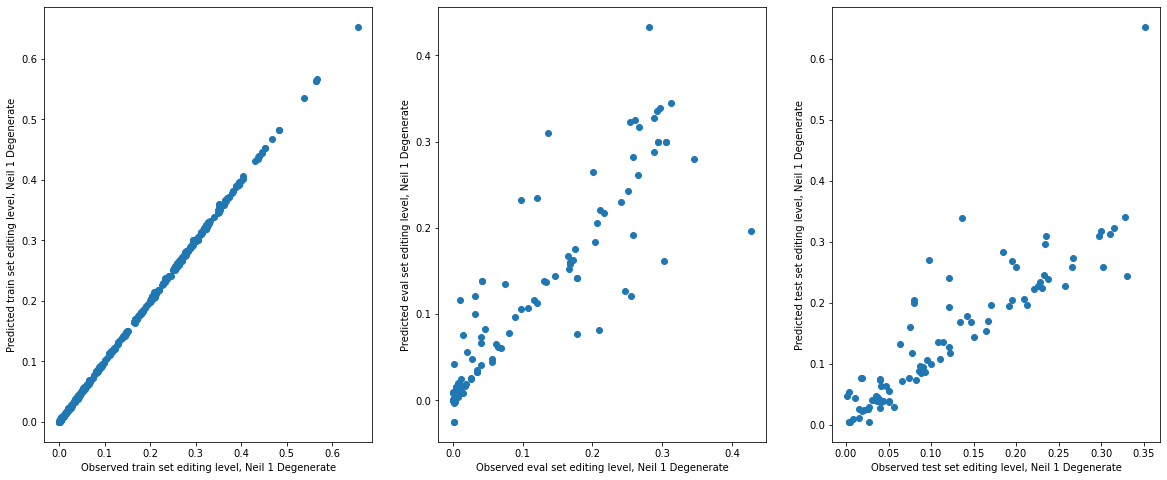

In [27]:
#plot the test set predictions 
matplotlib.rcParams['figure.figsize'] = [20, 8]
plt.subplot(1,3,1)
plt.plot(list(train_y),list(train_pred),'o')
plt.xlabel("Observed train set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted train set editing level, Neil 1 Degenerate")
plt.subplot(1,3,2)
plt.plot(list(eval_y),list(eval_pred),'o')
plt.xlabel("Observed eval set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted eval set editing level, Neil 1 Degenerate")
plt.subplot(1,3,3)
plt.plot(list(test_y),list(test_pred),'o')
plt.xlabel("Observed test set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted test set editing level, Neil 1 Degenerate")

plt.show()

In [28]:
import plotnine
from plotnine import *
test_df=pd.DataFrame({'Observed':test_y,
                     'Predicted':test_pred,
                     'Dataset':'TTYH2_COMP'})

In [29]:
#calculate R^2, which is representative of variance explained 
# https://datascienceplus.com/extreme-gradient-boosting-with-r/
# https://arxiv.org/pdf/1706.06060.pdf

residuals = test_y - test_pred

y_test_mean = np.mean(test_pred)
print(y_test_mean)
#calculate total sum of squares 
tss=sum((test_y-y_test_mean)*(test_y-y_test_mean))
print(tss)
# Calculate residual sum of squares
rss =  sum(residuals*residuals)
print(rss)
# Calculate R-squared
rsq  =  1 - (rss/tss)
print('The R-square of the test data is ', round(rsq,3), '\n')

0.13997278
0.9021925106745678
0.2865552803220385
The R-square of the test data is  0.682 



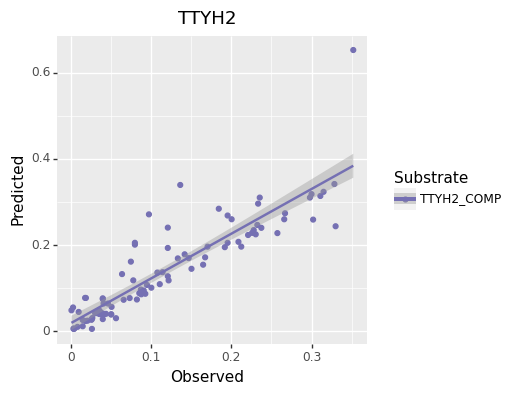

<ggplot: (8754292643185)>


In [30]:
plotnine.options.figure_size = (4, 4)

p=(ggplot(test_df, aes('Observed', 'Predicted', color='factor(Dataset)'))
 + geom_point()
 + stat_smooth(method='lm')
 + scale_color_manual(values=['#7570b3'],name="Substrate")
 + ggtitle("TTYH2"))
print(p)
ggsave(plot=p, filename='TTYH2.comp.substrate.pdf',format='pdf',width=4,height=4,units='in')


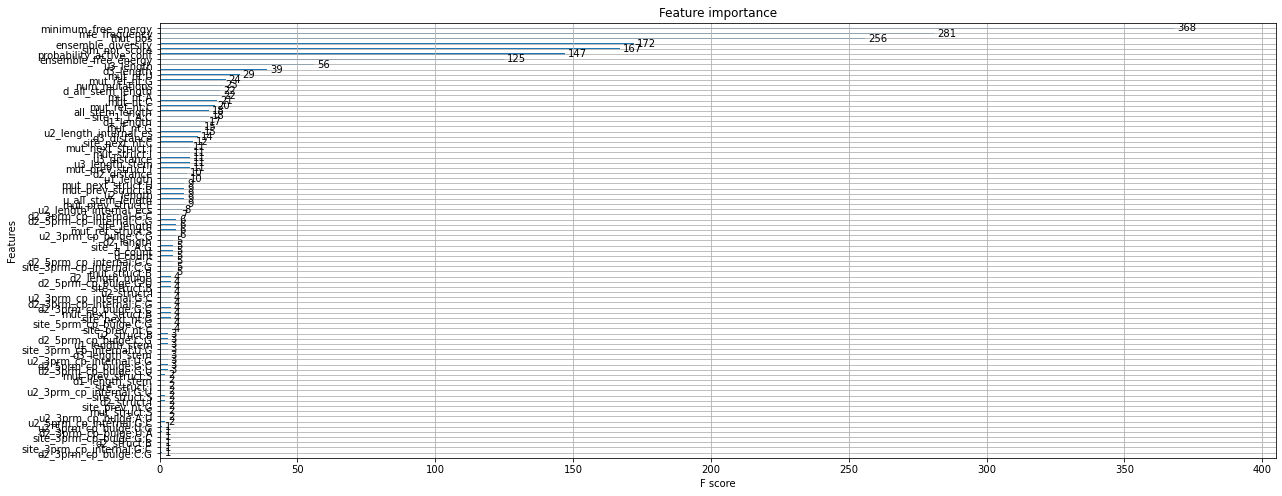

In [31]:
###### matplotlib.rcParams['figure.figsize'] = [15, 15]
xgboost.plot_importance(bst)

In [32]:
fscores=bst.get_fscore()
total=sum(list(fscores.values()))
normed_fscores={} 
for feat in fscores: 
    normed_fscores[feat]=fscores[feat]/total
#print(normed_fscores)
outf=open('TTYH2.norm.fscores.tsv','w')
for feat in normed_fscores: 
    outf.write(feat+'\t'+str(normed_fscores[feat])+'\n')
outf.close()

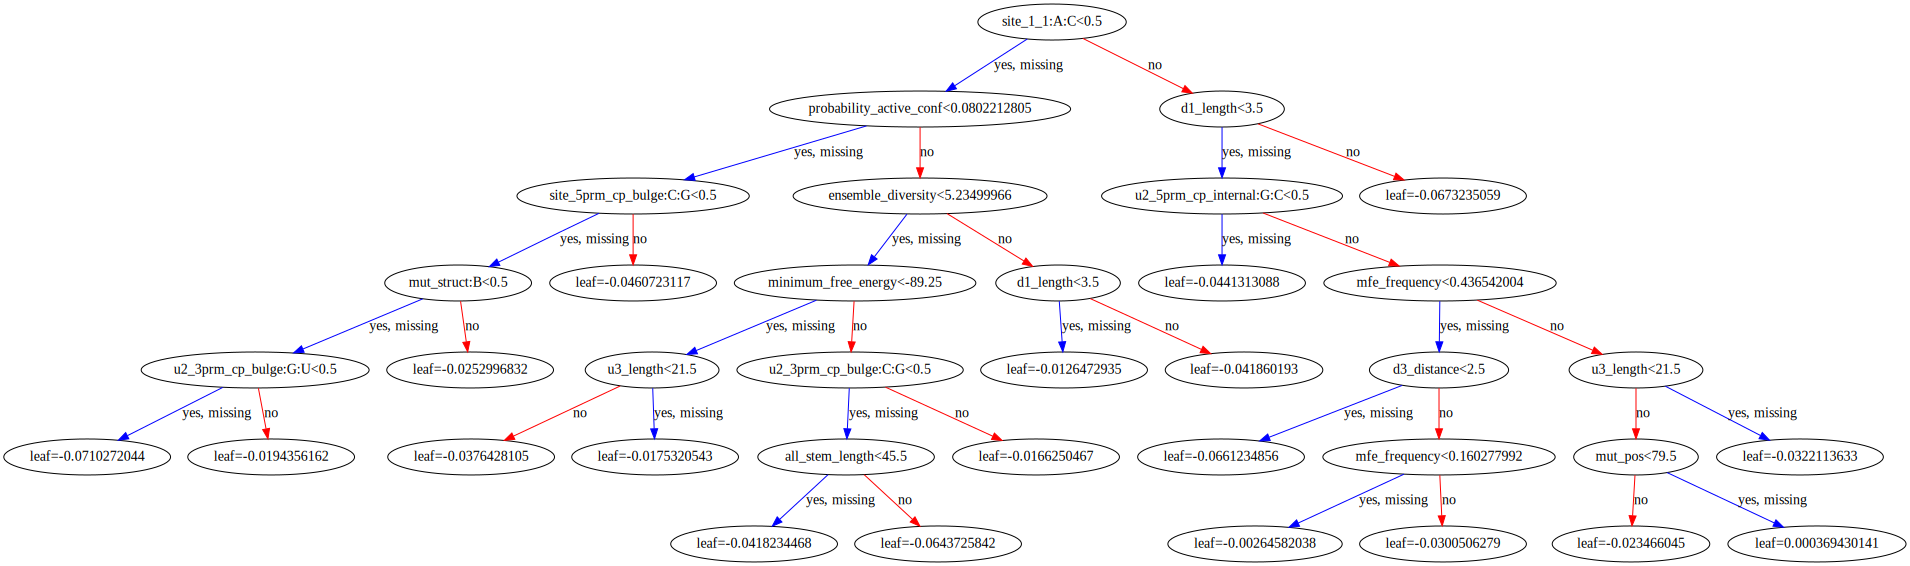

In [33]:
xgboost.to_graphviz(bst, num_trees=2)


In [34]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)
shap_values.shape

(93, 99)

In [35]:
test_y=pd.DataFrame(test_y)
max_index=test_y.index[test_y['editing_value'] == max(test_y['editing_value'])]
max_row=test_y.index.get_loc(max_index[0])
# visualize prediction for isoform with the highest editing level 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[max_row,:], test_X.iloc[max_row,:])

In [36]:
 max(test_y['editing_value'])

0.35200000000000004

In [37]:
# visualize prediction for isoform with the lowest editing level 
shap.initjs()
min_index=test_y.index[test_y['editing_value'] == min(test_y['editing_value'])]
min_row=test_y.index.get_loc(min_index[0])
shap.force_plot(explainer.expected_value, shap_values[min_row,:], test_X.iloc[min_row,:])

In [38]:
 min(test_y['editing_value'])

0.001

In [39]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,train_X)

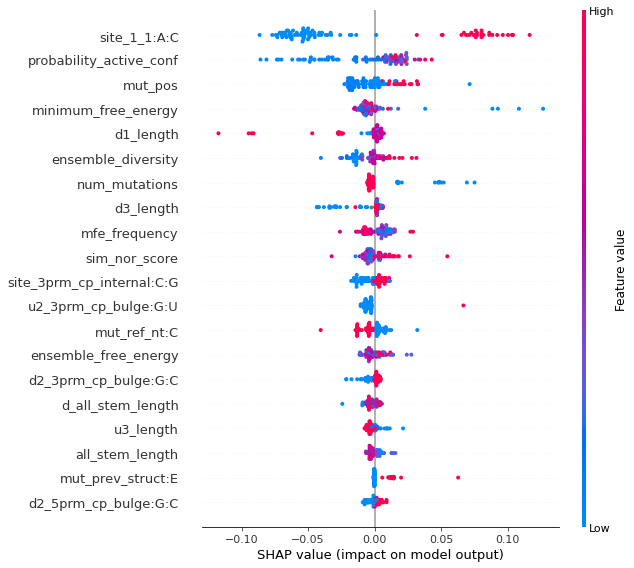

In [40]:
## summarize the effect of all the features 
shap.summary_plot(shap_values, test_X,show=False)
plt.savefig("TTYH2.comp.shap.pdf", format='pdf',width=30,height=10,dpi=300,bbox_inches="tight")


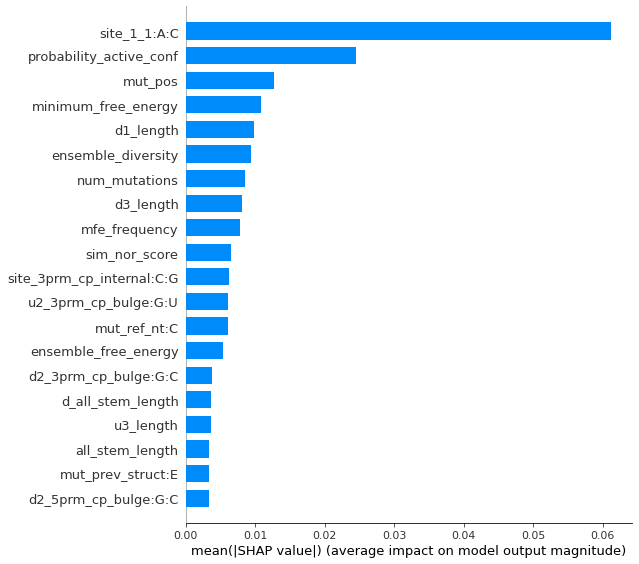

In [41]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

In [42]:
mean_abs_shap_vals=np.mean(abs(shap_values),axis=0)
features=test_X.columns
shap_dict=pd.DataFrame({'feature':features,
          'mean_abs_shap':mean_abs_shap_vals})
shap_dict.to_csv("TTYH2_comp_shap_mean_abs.txt",index=False,sep='\t')

In [43]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(test_X)
shap_interaction_values.shape

(93, 99, 99)

In [44]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [45]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [46]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
iplot([trace],show_link=False)


## Computational Dataset: Feature Subsets<a name='4'>
<a href=#outline>Home</a>

In [ ]:
shap_values=pd.DataFrame(shap_values,columns=Cols)

In [ ]:
from feature_subsets import * 
subset_names=["sub_site_seq","thermodynamic","u1_d1","mut","site","u","d","u_d","mut_site","no_up","no_down","site_struct","site_seq","mut_seq","mut_seq_site","no_mut","overall_structure"]
subset_contribs=[]
for subset in [sub_site_seq,thermodynamic,u1_d1,mut,site,u,d,u_d,mut_site,no_up,no_down,site_struct,site_seq,mut_seq,mut_seq_site,no_mut,overall_structure]: 
  print(subset)
  cur_features=filter_features(shap_values,subset)
  cur_feature_shap=shap_values[cur_features].values 
  cur_feature_data_X=test_X[cur_features]
  shap.summary_plot(cur_feature_shap, cur_feature_data_X)#,sort=False,max_display=50)
  contrib=shap_contribs_subgroup(shap_values,subset)
  subset_contribs.append(contrib)
  print("Contribution/Total:"+str(contrib))

In [ ]:
subset_contrib_df=pd.DataFrame({'Subset':subset_names,
                               'Contribution':[100*i for i in subset_contribs]})

In [ ]:
subset_contrib_df

In [ ]:
subset_contrib_df=subset_contrib_df.sort_values(by=['Contribution'],ascending=False)
subset_contrib_df.reset_index(inplace=True, drop=True) 

In [ ]:
from pandas.api.types import CategoricalDtype

In [ ]:
subset_cat = CategoricalDtype(categories=list(subset_contrib_df['Subset']), ordered=True)

# Cast the existing categories into the new category. Due to a bug in pandas
# we need to do this via a string.
subset_contrib_df['Subset_Cat'] = subset_contrib_df['Subset'].astype(str).astype(subset_cat)


In [ ]:
subset_contrib_df

In [ ]:
p=(ggplot(subset_contrib_df, aes('Subset_Cat', 'Contribution'))
 + geom_bar(stat='identity')
 + xlab("Feature Subset")
 + ylab("Percent Contribution to Predictions")
 + theme(axis_text_x=element_text(angle=90))
)
ggsave(plot=p, filename='TTYH2.comp.subset.importance.pdf',format='pdf',width=5,height=4,units='in')
p

## No mut features <a name='5'>
<a href=#outline>Home</a>

In [ ]:
## Read in the data 
import pandas as pd 
import feature_subsets
data=pd.read_csv("../../xin_feature_matrices/ttyh2_computational.features.csv",header=0,sep=',',index_col=0)
#drop all mut features
cur_features=filter_features(data,feature_subsets.mut)
cur_features.remove('mut_pos')
data=data.drop(cur_features,axis=1)
#data.head

In [ ]:
#remove any null editing level values 
data=data[~data["editing_value"].isnull().values]

In [ ]:
data=format_for_xgboost(data)
random.seed(1234)
train_split,eval_split,test_split=split_train_test_eval_by_mut_pos(data)

In [ ]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [ ]:
#Remove any null features 
train_null=get_high_missingness_features(train_split)
eval_null=get_high_missingness_features(eval_split)
test_null=get_high_missingness_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [ ]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
to_drop.append("mut_pos")
print("\n".join(to_drop))

In [ ]:
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [ ]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)

eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)

test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [ ]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


In [ ]:
## format matrixes for xgboost 
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [ ]:
## set model training parameters 
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 
param['eval_metric'] = ['auc','mae','map','aucpr','rmse']

In [ ]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [ ]:
num_round = 1000
random.seed(1234)

bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

In [ ]:
# save to binary file for faster loading
bst.save_model('ttyh2.computational.nomut.model')
# save model to text file 
bst.dump_model('ttyh2.computational.nomut.raw.txt')


In [ ]:
## get model predictions on the test, training, and eval splits 
test_pred = bst.predict(dtest)
train_pred=bst.predict(dtrain)
eval_pred=bst.predict(deval)

In [ ]:
## Correlation values 
from scipy.stats import spearmanr,pearsonr
spearman_train=spearmanr(train_y,train_pred)
spearman_eval=spearmanr(eval_y,eval_pred)
spearman_test=spearmanr(test_y,test_pred)

pearson_train=pearsonr(train_y,train_pred)
pearson_eval=pearsonr(eval_y,eval_pred)
pearson_test=pearsonr(test_y,test_pred)

print("Spearman correlation:")
print("Train:"+str(spearman_train))
print("Eval:"+str(spearman_eval))
print("Test:"+str(spearman_test))
print("\n")
print("Pearson correlation:")
print("Train:"+str(pearson_train))
print("Eval:"+str(pearson_eval))
print("Test:"+str(pearson_test))

In [ ]:
## MAE
from sklearn.metrics import mean_absolute_error
mae_train=mean_absolute_error(train_y,train_pred)
print("MAE Train:"+str(mae_train))

mae_eval=mean_absolute_error(eval_y,eval_pred)
print("MAE Eval:"+str(mae_eval))

mae_test=mean_absolute_error(test_y,test_pred)
print("MAE Test:"+str(mae_test))


In [ ]:
## MAPE
pseudocount=0.01
mape_train=np.mean(np.abs((train_y - train_pred) /(pseudocount+train_y))) * 100
print("MAPE Train:"+str(mape_train)+"%")

mape_eval=np.mean(np.abs((eval_y - eval_pred) /(pseudocount+eval_y))) * 100
print("MAPE Eval:"+str(mape_eval)+"%")

mape_test=np.mean(np.abs((test_y - test_pred) /(pseudocount+test_y))) * 100
print("MAPE Test:"+str(mape_test)+"%")

In [ ]:
## RMSE
from sklearn.metrics import mean_squared_error
import math 
rmse_train=math.sqrt(mean_squared_error(train_y,train_pred))
print("RMSE Train:"+str(rmse_train))

rmse_eval=math.sqrt(mean_squared_error(eval_y,eval_pred))
print("RMSE Eval:"+str(rmse_eval))

rmse_test=math.sqrt(mean_squared_error(test_y,test_pred))
print("RMSE Test:"+str(rmse_test))


In [ ]:
## PRC 
## PRC only valid for binary outcomes. 
## Editing levels < 0.2 are labeled as "0". 
## Editing levels >= 0.2 are labeled as "1". 

from sklearn.metrics import auc, precision_recall_curve

precision_train,recall_train,prc_thresholds_train=precision_recall_curve(train_y>=0.2,train_pred)
precision_eval,recall_eval,prc_thresholds_eval=precision_recall_curve(eval_y>=0.2,eval_pred)
precision_test,recall_test,prc_thresholds_test=precision_recall_curve(test_y>=0.2,test_pred)

auprc_train=auc(recall_train,precision_train)
auprc_eval=auc(recall_eval,precision_eval)
auprc_test=auc(recall_test,precision_test)

plt.plot(recall_train,precision_train,'r',label="Train:"+str(round(auprc_train,2)))
plt.plot(recall_eval,precision_eval,'g',label="Eval:"+str(round(auprc_eval,2)))
plt.plot(recall_test,precision_test,'b',label="Test:"+str(round(auprc_test,2)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PRC")
plt.legend()

In [ ]:
## ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr_train,tpr_train,roc_thresholds_train=roc_curve(train_y>=0.2,train_pred)
fpr_eval,tpr_eval,roc_thresholds_eval=roc_curve(eval_y>=0.2,eval_pred)
fpr_test,tpr_test,roc_thresholds_test=roc_curve(test_y>=0.2,test_pred)

auroc_train=roc_auc_score(train_y>=0.2,train_pred)
auroc_eval=roc_auc_score(eval_y>=0.2,eval_pred)
auroc_test=roc_auc_score(test_y>=0.2,test_pred)

plt.plot(fpr_train,tpr_train,'r',label="Train:"+str(round(auroc_train,2)))
plt.plot(fpr_eval,tpr_eval,'g',label="Eval:"+str(round(auroc_eval,2)))
plt.plot(fpr_test,tpr_test,'b',label="Test:"+str(round(auroc_test,2)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()

In [ ]:
#plot the test set predictions 
matplotlib.rcParams['figure.figsize'] = [20, 8]
plt.subplot(1,3,1)
plt.plot(list(train_y),list(train_pred),'o')
plt.xlabel("Observed train set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted train set editing level, Neil 1 Degenerate")
plt.subplot(1,3,2)
plt.plot(list(eval_y),list(eval_pred),'o')
plt.xlabel("Observed eval set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted eval set editing level, Neil 1 Degenerate")
plt.subplot(1,3,3)
plt.plot(list(test_y),list(test_pred),'o')
plt.xlabel("Observed test set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted test set editing level, Neil 1 Degenerate")

plt.show()

In [ ]:
matplotlib.rcParams['figure.figsize'] = [15, 15]
xgboost.plot_importance(bst)

In [ ]:
xgboost.to_graphviz(bst, num_trees=2)


In [ ]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)
shap_values.shape

In [ ]:
test_y=pd.DataFrame(test_y)
max_index=test_y.index[test_y['editing_value'] == max(test_y['editing_value'])]
max_row=test_y.index.get_loc(max_index[0])
# visualize prediction for isoform with the highest editing level 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[max_row,:], test_X.iloc[max_row,:])

In [ ]:
# visualize prediction for isoform with the lowest editing level 
shap.initjs()
min_index=test_y.index[test_y['editing_value'] == min(test_y['editing_value'])]
min_row=test_y.index.get_loc(min_index[0])
shap.force_plot(explainer.expected_value, shap_values[min_row,:], test_X.iloc[min_row,:])

In [ ]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,train_X)

In [ ]:
# summarize the effect of all the features 
shap.summary_plot(shap_values, test_X)


In [ ]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

In [ ]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(test_X)
shap_interaction_values.shape

In [ ]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [ ]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [ ]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
iplot([trace],show_link=False)
